In [1]:
import matplotlib.pyplot as plt
from matplotlib  import cm
import matplotlib.animation
plt.rcParams.update({'font.size': 8})

%matplotlib ipympl
import numpy as np
import pandas as pd
import random

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import joblib
import time
from numba_progress import ProgressBar
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

from utility import get_imsd, get_imsd_windowed, get_emsd, get_emsd_windowed, fit_hist, MB_2D,\
                    normal_distr, lorentzian_distr, get_trajs, speed_windowed, theta_windowed, \
                    get_smooth_trajs, get_velocities

from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx 
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import DBSCAN

show_verb = False
save_verb = True
anim_show_verb = False

In [2]:
traj_verb = "stardist"

if traj_verb == "trackpy": 
    rawTrajs = pd.read_parquet("../tracking/results/tracking_data/trackpy_pre_merge.parquet")
    nDrops = int(len(rawTrajs.loc[rawTrajs.frame==0]))
    red_particle_idx = 17
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, 30, 2)

    res_path = "results"
    analysis_data_path = "analysis_data"

elif traj_verb == "hough":
    rawTrajs = pd.read_parquet("../tracking/results/tracking_data/hough/tracking_hough_trackpy_linking.parquet")
    nDrops = int(len(rawTrajs.loc[rawTrajs.frame==0]))
    red_particle_idx = 17
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, 30, 2)
    
    res_path = "hough_results"
    analysis_data_path = "hough_analysis_data"

elif traj_verb == "stardist":
    rawTrajs = pd.read_parquet("../tracking/stardist_res/sharp/df_linked.parquet")
    nDrops = int(len(rawTrajs.loc[rawTrajs.frame==0]))
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, 30, 2)
    red_particle_idx = 8

    res_path = "stardist_results" 
    analysis_data_path = "stardist_analysis_data"
else:
    raise ValueError("traj_verb must be either 'trackpy' or 'hough'")


colors = rawTrajs.loc[rawTrajs.frame == 0, 'color'].values
nFrames = int(max(rawTrajs.frame) + 1)
fps = 10
print(f"Number of Droplets: {nDrops}")
print(f"Number of Frames: {nFrames} at {fps} fps --> {nFrames/10:.2f} s")

# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print("Windowed analysis args:")

startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"window of {window/10} s, stride of {stride/10} s --> {nSteps} steps")

# step 10 with a 10 fps video --> 1 s
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

Number of Droplets: 50
Number of Frames: 30000 at 10 fps --> 3000.00 s
Windowed analysis args:
window of 320.0 s, stride of 10.0 s --> 268 steps


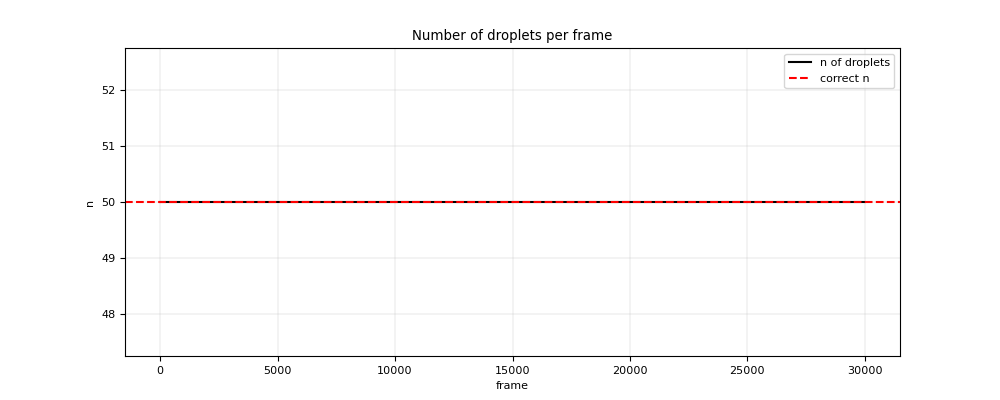

In [506]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(rawTrajs.groupby("frame").size(), color = "k", label = "n of droplets")
ax.axhline(nDrops, color = "r", linestyle = "--", label = "correct n")
ax.set(xlabel = "frame", ylabel = "n")
ax.set_title("Number of droplets per frame")
ax.grid(linewidth = 0.2)
ax.legend()
plt.show()

In [ ]:
n_frames = 30000
frames = np.arange(0, n_frames, 1)
# cutoff distance is 2 times the mean radius the droplets have at that frame
mean_d = 2*rawTrajs.groupby("frame").mean().r.values

n = 50
random.seed(5)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]

# spectral velocity analysis ?

In [475]:
trajs = []
for i in range(0, 50):
    p = rawTrajs.loc[rawTrajs.particle == i, ["x","y"]]
    trajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

In [491]:
v = ys.speed_ensemble(trajs, step = 10)
v.shape

(150050,)

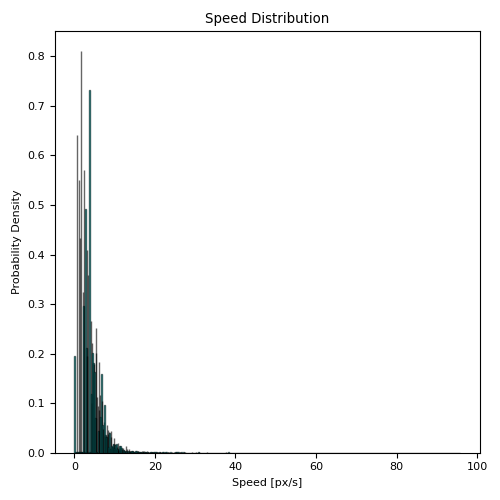

In [492]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(v, bins=1000, density=True, color="#00FFFF", ec=(0, 0, 0, 0.6))
ax.set_xlabel("Speed [px/s]")
ax.set_ylabel("Probability Density")
ax.set_title("Speed Distribution")
plt.tight_layout()
plt.show()

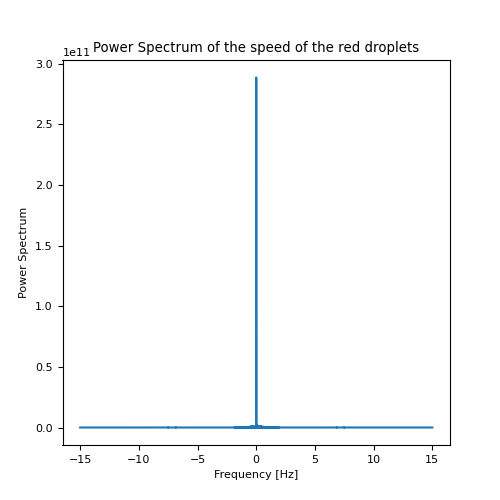

In [481]:
ps = np.abs(np.fft.fft(v))**2
time_step = 1 / 30
freqs = np.fft.fftfreq(v.size, time_step)
idx = np.argsort(freqs)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(freqs[idx], ps[idx])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Power Spectrum")
ax.set_title("Power Spectrum of the speed of the red droplets")
plt.show()

# graph based analysis

In [ ]:
frame = 25000
X = np.array(rawTrajs.loc[rawTrajs.frame == frame, ['x', 'y']])
# create dictionary with positions of the agents
dicts = {}
for i in range(len(X)):
    dicts[i] = (X[i, 0], X[i, 1])
# generate random geometric graph with cutoff distance 2.2 times the mean diameter the droplets have at that frame
G = nx.random_geometric_graph(len(dicts), mean_d[frame]*2.2, pos=dicts, dim=2)
node_pos = nx.get_node_attributes(G, 'pos')
vor = Voronoi(np.asarray(list(node_pos.values())))
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)
nx.draw(G, pos=node_pos, node_size=10, node_color=colors, with_labels=True, ax=ax)
ax.set(xlim=(0, 900), ylim=(900, 0), title=f"frame {frame}", xlabel="x [px]", ylabel="y [px]")
plt.show()

In [ ]:
frames = np.arange(0, n_frames, 1)
clustering = np.zeros((10, len(frames)))
n_cycles = np.zeros((10, len(frames)), dtype=int)
dim_cycles_list = []
n_conn_comp = np.zeros((10, len(frames)), dtype=int)
conn_comp_list = []
progress_bar = tqdm(total=len(frames)*10)

for ind, factor in enumerate(np.linspace(1.1, 2.2, 10)):
    connected_components = []
    dim_cycles = []
    for frame in frames:
        X = np.array(rawTrajs.loc[rawTrajs.frame == frame, ['x', 'y']])
        dicts = {}
        for j in range(len(X)):
            dicts[j] = (X[j, 0], X[j, 1])
        
        temp = nx.random_geometric_graph(len(dicts), mean_d[frame]*factor, pos=dicts, dim=2)
        clustering[ind, frame] = np.mean(list(nx.clustering(temp).values()))

        cycles = nx.cycle_basis(temp)
        n_cycles[ind, frame] = int(len(cycles))
        dim_cycles.append([len(cycles[i]) for i in range(n_cycles[ind, frame])])

        conn_comp = [len(c) for c in sorted(nx.connected_components(temp), key=len, reverse=True)]
        n_conn_comp[ind, frame] = len(conn_comp)
        connected_components.append(conn_comp)
        progress_bar.update(1)

    conn_comp_list.append(connected_components)
    dim_cycles_list.append(dim_cycles)
progress_bar.close()

mean_dim_conn_comp = np.zeros((10, len(frames)))
for frame in frames:
    mean_dim_conn_comp[:, frame] = [np.mean(conn_comp_list[i][frame]) for i in range(10)]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
imshow = ax.imshow(n_conn_comp, aspect='auto', extent=[0, n_frames, 2.2, 1.1], cmap='viridis')
fig.colorbar(imshow, ax=ax)
ax.set(xlabel="frame", ylabel="factor", title="Number of connected components")
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
imshow = ax.imshow(n_cycles, aspect='auto', extent=[0, n_frames, 2.2, 1.1], cmap='viridis')
fig.colorbar(imshow, ax=ax)
ax.set(xlabel="frame", ylabel="factor", title="Number of cycles")
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
imshow = ax.imshow(clustering, aspect='auto', extent=[0, n_frames, 2.2, 1.1], cmap='viridis')
fig.colorbar(imshow, ax=ax)
ax.set(xlabel="frame", ylabel="factor", title="Clustering coefficient")
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
imshow = ax.imshow(mean_dim_conn_comp, aspect='auto', extent=[0, n_frames, 2.2, 1.1], cmap='viridis')
fig.colorbar(imshow, ax=ax)
ax.set(xlabel="frame", ylabel="factor", title="Mean dimension of connected components")
plt.show()


In [ ]:
frame = 20000
fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 6))
ax.bar(hist_bins_dim_cycles[:-1], dim_cycles_count[frame], width=1, color="#EE4B2B", label = "dim of cycles")
ax1.bar(hist_bins_degree[:-1], degree_count[frame], width = 1, color = "green", label="degree")
ax2.bar(hist_bins_01[:-1], centrality_count[frame], width = .01, color = "orange", label="centrality")
ax2.bar(hist_bins_01[:-1], betweenness_count[frame], width = .01, color = "blue", label="betweenness")
ax2.bar(hist_bins_01[:-1], clustering_count[frame], width = .01, color = "red", label="clustering")
ax.set(title = f"frame {frame}")
ax.legend()
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot = ax.imshow(dim_cycles_count.T, cmap="viridis", aspect="auto", extent=[0, n_frames, 0, 51], origin="lower")
ax.set(xlabel="frame", ylabel="dim_cycles", title="dim_cycles")
fig.colorbar(plot)
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
plot = ax.imshow(degree_count.T, cmap="viridis", aspect="auto", extent=[0, n_frames, 0, 1], origin="lower")
ax.set(xlabel="frame", ylabel="degree", title="degree")
fig.colorbar(plot)
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
plot = ax.imshow(centrality_count.T, cmap="viridis", aspect="auto", extent=[0, n_frames, 0, 1], origin="lower")
ax.set(xlabel="frame", ylabel="centrality_count", title="centrality_count")
fig.colorbar(plot)
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
plot = ax.imshow(betweenness_count.T, cmap="viridis", aspect="auto", extent=[0, n_frames, 0, 1], origin="lower")
ax.set(xlabel="frame", ylabel="betweenness_count", title="betweenness_count")
fig.colorbar(plot)
plt.show()

In [ ]:
mean_n_edges_b = np.mean(np.delete(degree, red_particle_idx, axis=1), axis = 1)
mean_n_edges_b_std = np.std(np.delete(degree, red_particle_idx, axis=1), axis = 1)
mean_n_edges_r = degree[:,red_particle_idx]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(mean_n_edges_b, 'b')
ax.fill_between(np.arange(0, n_frames, 1), mean_n_edges_b - mean_n_edges_b_std, mean_n_edges_b + mean_n_edges_b_std, color='b', alpha=0.2)
ax.plot(mean_n_edges_r, 'r')
plt.show()

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 4))
ax.plot(frames, centrality[:, red_particle_idx], color="red", label="centrality")
ax.plot(frames, np.mean(np.delete(centrality, red_particle_idx, axis=1), axis = 1), color="blue", label="mean centrality")
ax1.plot(frames, betweenness[:, red_particle_idx], color="red", label="betweenness")
ax1.plot(frames,np.mean(np.delete(betweenness, red_particle_idx, axis=1), axis = 1), color="blue", label="mean betweenness")
ax.set(xlabel="frame", ylabel="centrality", title="centrality over time")
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(frames, clustering[:, red_particle_idx], color="red", label="clustering")
ax.plot(frames, np.mean(np.delete(clustering, red_particle_idx, axis=1), axis = 1), color="blue", label="mean clustering")
ax.set(xlabel="frame", ylabel="clustering", title="clustering over time")
ax.legend()
plt.show()

## simple connection graph

In [45]:
clust_id_list = []
for frame in tqdm(frames):
    X = np.array(rawTrajs.loc[rawTrajs.frame == frame, ['x', 'y']])
    dicts = {}
    for j in range(len(X)):
        dicts[j] = (X[j, 0], X[j, 1])
    temp = nx.random_geometric_graph(len(dicts), mean_d[frame]*1.4, pos=dicts, dim=2)
    clust_id = np.ones(len(X), dtype=int)*-1
    for id, c in enumerate(list(nx.connected_components(temp))):
        clust_id[list(c)] = id
    clust_id_list += list(clust_id)
clustered_trajs = rawTrajs.copy()
clustered_trajs["cluster_id"] = clust_id_list
clustered_trajs["cluster_color"] = [colors[i] for i in clust_id_list]
clustered_trajs.to_parquet(f"{res_path}/clustering/trajs_simple_connections.parquet")

100%|██████████| 30000/30000 [02:11<00:00, 228.27it/s]


## greedy community detection

In [ ]:
if 0: 
    node_colors = []
    for frame in tqdm(frames):
        G = random_geometric_graphs[frame]
        positions = nx.get_node_attributes(G, 'pos')
        communities = greedy_modularity_communities(G, resolution = 0.1)
        community_colors = {}
        for i, community_set in enumerate(communities):
            for node in community_set:
                community_colors[node] = i
        node_colors.append([community_colors[node] for node in G.nodes])
    clustered_trajs = rawTrajs.copy()
    clustered_trajs["cluster_id"] = np.array(node_colors).flatten()
    clustered_trajs["cluster_color"] = [colors[i] for i in np.array(node_colors).flatten()]
    clustered_trajs.to_parquet(f"{res_path}/clustering/trajs_greedy_clustered.parquet")
else:
    clustered_trajs = pd.read_parquet(f"{res_path}/clustering/trajs_greedy_clustered.parquet")
"""
# to remove edges between different communities, only for visualization purposes, the actual graph is not changed
new_G = G.copy()
for edge in G.edges:
    if community_colors[edge[0]] != community_colors[edge[1]]:
        new_G.remove_edge(*edge)
"""

frame = 10000
df = clustered_trajs.loc[rawTrajs.frame == frame]
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4.5))
nx.draw_networkx(random_geometric_graphs[frame], pos=nx.get_node_attributes(random_geometric_graphs[frame], 'pos'),\
                         node_size = 50, node_color = df.cluster_color.values, ax = ax)
ax.set(xlim=(0, 900), ylim=(900, 0), title=f"frame {frame}, communities", xlabel="x [px]", ylabel="y [px]")
for i in range(50):
    ax1.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), mean_d[frame]/2, color=df.cluster_color.values[i], fill=True))
ax1.set(xlim=(0, 900), ylim=(900, 0), title=f"frame {frame}, communities", xlabel="x [px]", ylabel="y [px]")
plt.show()

In [ ]:
if 1:
    community_sizes = []
    for frame in tqdm(clustered_trajs.frame.unique()):
        df = clustered_trajs.loc[clustered_trajs.frame == frame]
        community_sizes.append(np.mean(df.groupby("cluster_id").size().values))
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(community_sizes)
plt.show()

In [ ]:
initFrame = 0

fig = plt.figure(figsize = (5, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    ax.clear()
    nx.draw_networkx(random_geometric_graphs[frame], pos=nx.get_node_attributes(random_geometric_graphs[frame], 'pos'),\
                         node_size = 50, node_color = node_colors[frame], ax = ax) 
    ax.set(xlim=(0, 900), ylim=(900, 0), title=f"frame {frame}, communities", xlabel="x [px]", ylabel="y [px]")
    return ax

ax = fig.add_subplot(111)
title = ax.set_title('DBSCAN - frame = 0')
nx.draw_networkx(random_geometric_graphs[initFrame], pos=nx.get_node_attributes(random_geometric_graphs[initFrame], 'pos'),\
                         node_size = 50, node_color = node_colors[initFrame], ax = ax)
ax.set(xlim=(0, 900), ylim=(900, 0), title=f"frame {initFrame}, communities", xlabel="x [px]", ylabel="y [px]")

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(initFrame, rawTrajs.frame.max(), 2), interval = 5, blit=False)
if 1:
    writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
    ani.save(f'{res_path}/clustering/clustering_greedy.mp4', writer=writer, dpi = 300)
plt.close()

## DBSCAN

In [ ]:
if 0:
    cluster_centroids = {}
    labels = np.ones((n_frames, 50), dtype=int)*-1
    for frame in tqdm(rawTrajs.frame.unique()):
        positions = rawTrajs.loc[rawTrajs.frame == frame, ['x', 'y']].values
        labels[frame] = DBSCAN(eps=mean_d[frame]*2.2, min_samples=2).fit_predict(positions)
    clustered_trajs = rawTrajs.copy()
    clustered_trajs['cluster_id'] = labels.flatten()
    clustered_trajs['cluster_color'] = [colors[i] for i in labels.flatten()]
    display(clustered_trajs)
    clustered_trajs.to_parquet(f"{res_path}/clustering/trajs_dbscan_clustered.parquet")
    node_colors2 = clustered_trajs.cluster_color.values.reshape((n_frames, 50))
else:
    clustered_trajs = pd.read_parquet(f"{res_path}/clustering/trajs_dbscan_clustered.parquet")
    node_colors2 = clustered_trajs.cluster_color.values.reshape((n_frames, 50))

In [ ]:
# clusters cm position per frame
cluster_centroids = np.zeros((n_frames, 50, 2))
for frame in tqdm(clustered_trajs.frame.unique()):
    df = clustered_trajs.loc[clustered_trajs.frame == frame]
    for cluster_id in df.cluster_id.unique():
        df_cluster = df.loc[df.cluster_id == cluster_id]
        cluster_centroids[frame, cluster_id] = np.mean(df_cluster[['x', 'y']].values, axis=0)
cluster_centroids_r = np.linalg.norm(cluster_centroids, axis=2)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(cluster_centroids_r)
plt.show()

In [ ]:
community_sizes2 = []
for frame in tqdm(clustered_trajs.frame.unique()):
    df = clustered_trajs.loc[clustered_trajs.frame == frame]
    community_sizes2.append(np.mean(df.groupby("cluster_id").size().values))

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(community_sizes2)
plt.show()

In [ ]:
initFrame = 0

fig = plt.figure(figsize = (5, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    ax.clear()
    nx.draw_networkx(random_geometric_graphs[frame], pos=nx.get_node_attributes(random_geometric_graphs[frame], 'pos'),\
                     node_size = 50, node_color = node_colors[frame], ax = ax, with_labels=False)
    ax.set_title(f'DBSCAN + random geometric graph - frame = {frame}')
    ax.set(xlabel = 'X [px]', ylabel = 'Y [px]', xlim=(0, 900), ylim=(900, 0))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('DBSCAN + random geometric graph - frame = 0')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]', xlim=(0, 900), ylim=(900, 0))
nx.draw_networkx(random_geometric_graphs[initFrame], pos=nx.get_node_attributes(random_geometric_graphs[initFrame], 'pos'),\
                     node_size = 50, node_color = node_colors[initFrame], ax = ax, with_labels=False)
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(initFrame, clustered_trajs.frame.max(), 2), interval = 5, blit=False)
if 0: 
    writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
    ani.save(f'{res_path}/clustering/clustering_dbscan2.mp4', writer=writer, dpi = 300)
plt.show()

# graph based analysis of communities

### graph analysis with different clusters distinct

In [ ]:
# save the random geometric graphs for each frame and cluster in a dictionary
dict_res = {}
for frame in tqdm(clustered_trajs.frame.unique()):
    df = clustered_trajs.loc[clustered_trajs.frame == frame]
    labels = df.cluster_id.values
    unique_labels, counts = np.unique(labels, return_counts=True)
    for j, cluster_id in enumerate(unique_labels[counts>2]):
        df_cluster = df.loc[df.cluster_id == cluster_id]
        X = np.array(df_cluster[['x', 'y']])
        # create dictionary with positions of the agents
        dicts = {}
        for i in range(len(X)):
            dicts[i] = (X[i, 0], X[i, 1])
        # generate random geometric graph with cutoff distance 2.2 times the mean diameter the droplets have at that frame
        temp = nx.random_geometric_graph(len(dicts), mean_d[frame]*1.5, pos=dicts, dim=2)
        
        degree_count, _ = np.histogram(np.array([val for (_, val) in temp.degree()]) , bins=hist_bins_degree)
        centrality_count, _ = np.histogram(list(nx.degree_centrality(temp).values()), bins=hist_bins_01) 
        betweenness_count, _ = np.histogram(list(nx.betweenness_centrality(temp).values()), bins=hist_bins_01)
        clustering_count, _ = np.histogram(list(nx.clustering(temp).values()) , bins=hist_bins_01)

        cycles = nx.cycle_basis(temp)
        n_cycles = int(len(cycles))
        dim_cycles_count, _ = np.histogram([len(cycles[i]) for i in range(n_cycles)], bins=hist_bins_dim_cycles)
        
        dict_res[(frame, j)] = np.concatenate((degree_count, centrality_count, betweenness_count, clustering_count, dim_cycles_count))

In [ ]:
frames = [t[0] for t in list(dict_res.keys())]
clusters = [t[1] for t in list(dict_res.keys())]
max(clusters)

# graph based analysis with added clusters

In [57]:
hist_bins_degree = np.arange(0, 30, 1)
hist_bins_01 = np.arange(0, 1.01, 0.01)
hist_bins_dim_cycles = np.arange(0, 51, 1)

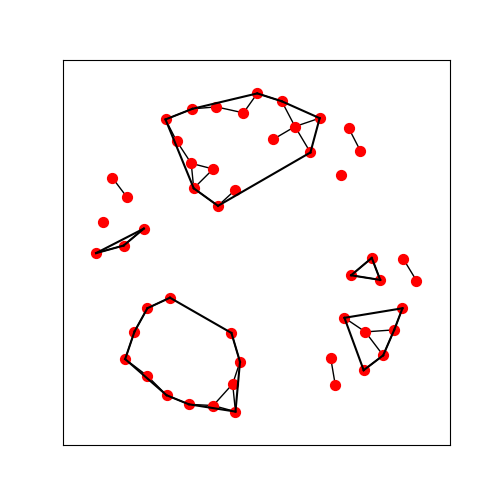

In [385]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
frame = 10000
df = clustered_trajs.loc[clustered_trajs.frame == frame]
X = np.array(rawTrajs.loc[rawTrajs.frame == frame, ['x', 'y']])
dicts = {}
for j in range(len(X)):
    dicts[j] = (X[j, 0], X[j, 1])
temp = nx.random_geometric_graph(len(dicts), mean_d[frame]*1.4, pos=dicts, dim=2)
labels = df.cluster_id.values
unique_labels, counts = np.unique(labels, return_counts=True)
#print(unique_labels, counts)
area = []
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(df.x, df.y, 'o')
nx.draw_networkx(temp, pos=nx.get_node_attributes(temp, 'pos'),\
                        node_size = 50, node_color = 'r', ax = ax, with_labels=False)
for j, cluster_id in enumerate(unique_labels[counts>2]):
    df_cluster = df.loc[df.cluster_id == cluster_id]
    #print(X.shape)
    X = np.array(df_cluster[['x', 'y']])
    hull = ConvexHull(X)
    for simplex in hull.simplices:
        ax.plot(X[simplex, 0], X[simplex, 1], 'k-')
plt.show()

In [397]:
frames

array([    0,     1,     2, ..., 29997, 29998, 29999])

In [409]:
clusters_area_count = np.zeros((len(frames), len(hist_bins_area)-1))
mean_cluster_area = np.zeros(len(frames))
hist_bins_area = np.arange(100, 2000, 100)
for frame in tqdm(clustered_trajs.frame.unique()):
    df = clustered_trajs.loc[clustered_trajs.frame == frame]
    labels = df.cluster_id.values
    unique_labels, counts = np.unique(labels, return_counts=True)
    area = []
    for j, cluster_id in enumerate(unique_labels[counts>2]):
        df_cluster = df.loc[df.cluster_id == cluster_id]
        X = np.array(df_cluster[['x', 'y']])
        hull = ConvexHull(X)
        area.append(hull.area)
    mean_cluster_area[frame] = np.mean(area)
    clusters_area_count[frame],  _ = np.histogram(area, bins=hist_bins_area)

100%|██████████| 30000/30000 [06:48<00:00, 73.43it/s] 


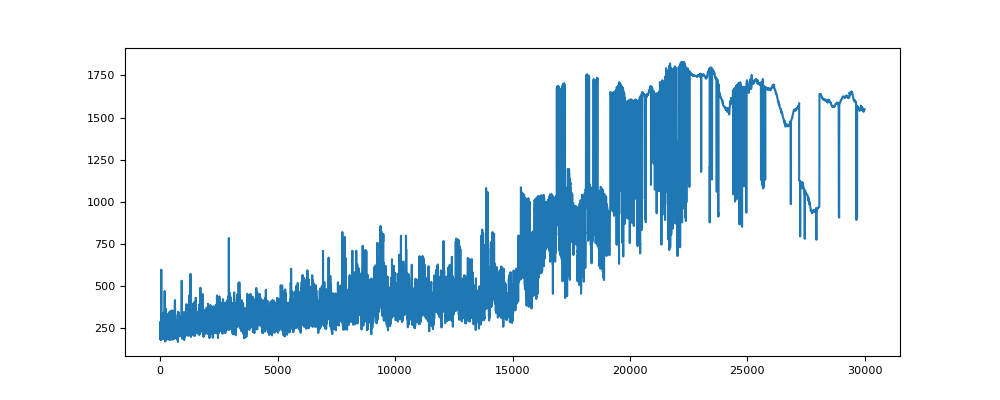

In [410]:
fig, ax = plt.subplots(1,1, figsize=(10, 4))
ax.plot(frames, mean_cluster_area)
plt.show()

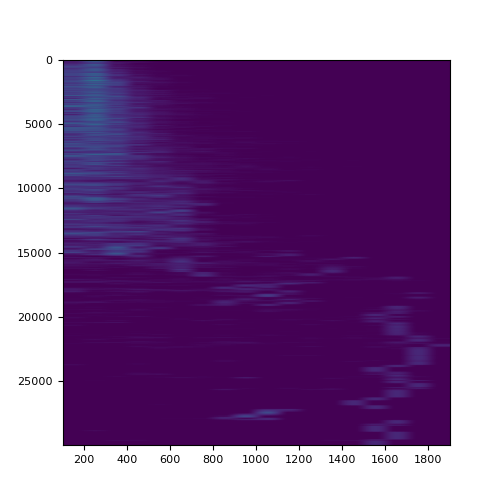

In [408]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.imshow(clusters_area_count, aspect='auto', cmap='viridis', extent=[hist_bins_area[0], hist_bins_area[-1], frames[-1], frames[0]])
plt.show()


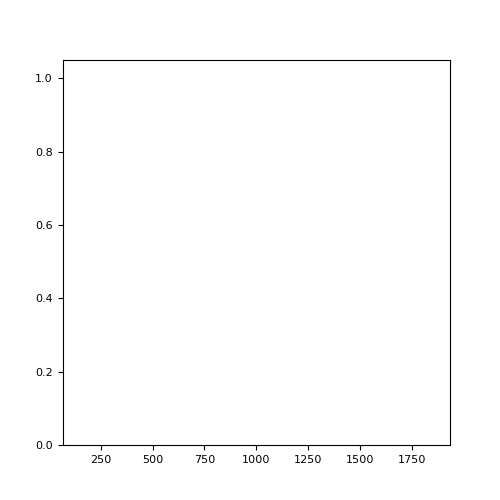

In [404]:
hist_bins_area = np.arange(100, 2000, 100)
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.bar((hist_bins_area[:-1] + hist_bins_area[1:])/2, clusters_area_count[20000])
plt.show()

In [239]:
# save the random geometric graphs for each frame and cluster in a dictionary
res = np.zeros((len(clustered_trajs.frame.unique()), 382))
for frame in tqdm(clustered_trajs.frame.unique()):
    df = clustered_trajs.loc[clustered_trajs.frame == frame]
    labels = df.cluster_id.values
    unique_labels, counts = np.unique(labels, return_counts=True)
    degree = []
    betweenness_centrality = []
    clustering = []
    degree_centrality = []
    dim_cycles = []
    tot_n_cycles = 0

    for j, cluster_id in enumerate(unique_labels[counts>2]):
        df_cluster = df.loc[df.cluster_id == cluster_id]
        X = np.array(df_cluster[['x', 'y']])
        # create dictionary with positions of the agents
        dicts = {}
        for i in range(len(X)):
            dicts[i] = (X[i, 0], X[i, 1])
        # generate random geometric graph with cutoff distance 2.2 times the mean diameter the droplets have at that frame
        temp = nx.random_geometric_graph(len(dicts), mean_d[frame]*1.5, pos=dicts, dim=2)
        degree += [val for (_, val) in temp.degree()]
        degree_centrality += list(nx.degree_centrality(temp).values())
        betweenness_centrality += list(nx.betweenness_centrality(temp).values())
        clustering += list(nx.clustering(temp).values())

        cycles = nx.cycle_basis(temp)
        tot_n_cycles += int(len(cycles))
        dim_cycles += [len(cycles[i]) for i in range(int(len(cycles)))]

    degree_count,      _ = np.histogram(degree , bins=hist_bins_degree)
    centrality_count,  _ = np.histogram(degree_centrality, bins=hist_bins_01) 
    betweenness_count, _ = np.histogram(betweenness_centrality, bins=hist_bins_01)
    clustering_count,  _ = np.histogram(clustering, bins=hist_bins_01)
    dim_cycles_count,  _ = np.histogram(dim_cycles, bins=hist_bins_dim_cycles)
    res[frame] =  np.concatenate(([frame], [len(unique_labels[counts>2])], [tot_n_cycles], degree_count, centrality_count, betweenness_count, clustering_count, dim_cycles_count))
label = ['frame'] + ['nClusters'] + ['nCycles'] + [f'degree_{i}' for i in range(len(hist_bins_degree[1:]))] + [f'centrality{i}' for i in range(len(hist_bins_01[1:]))] + [f'betweenness{i}' for i in range(len(hist_bins_01[1:]))] + [f'clustering{i}' for i in range(len(hist_bins_01[1:]))] + [f'dim_cycles_{i}' for i in range(len(hist_bins_dim_cycles[1:]))]
df_graph = pd.DataFrame(res, columns=label)
display(df_graph)
df_graph.to_parquet(f'{analysis_data_path}/graph_analysis.parquet')

# how to index the array
id_nClusters = np.argwhere(np.char.startswith(np.array(label), 'nClusters')==True)[0][0]
id_nCycles = np.argwhere(np.char.startswith(np.array(label), 'nCycles')==True)[0][0]
id_degree = np.argwhere(np.char.startswith(np.array(label), 'degree')==True)[0][0], np.argwhere(np.char.startswith(np.array(label), 'degree')==True)[-1][0]
id_centrality = np.argwhere(np.char.startswith(np.array(label), 'centrality')==True)[0][0], np.argwhere(np.char.startswith(np.array(label), 'centrality')==True)[-1][0]
id_betweenness = np.argwhere(np.char.startswith(np.array(label), 'betweenness')==True)[0][0], np.argwhere(np.char.startswith(np.array(label), 'betweenness')==True)[-1][0]
id_clustering = np.argwhere(np.char.startswith(np.array(label), 'clustering')==True)[0][0], np.argwhere(np.char.startswith(np.array(label), 'clustering')==True)[-1][0]
id_dim_cycles = np.argwhere(np.char.startswith(np.array(label), 'dim_cycles')==True)[0][0], np.argwhere(np.char.startswith(np.array(label), 'dim_cycles')==True)[-1][0] 

100%|██████████| 30000/30000 [07:13<00:00, 69.20it/s] 


,frame,nClusters,nCycles,degree_0,degree_1,degree_2,degree_3,degree_4,degree_5,degree_6,...,dim_cycles_40,dim_cycles_41,dim_cycles_42,dim_cycles_43,dim_cycles_44,dim_cycles_45,dim_cycles_46,dim_cycles_47,dim_cycles_48,dim_cycles_49
0,0.0,4.0,1.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,4.0,1.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,4.0,1.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3.0,1.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,1.0,0.0,5.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995.0,1.0,6.0,0.0,3.0,34.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,29996.0,1.0,6.0,0.0,3.0,34.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,29997.0,1.0,6.0,0.0,3.0,34.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,29998.0,1.0,6.0,0.0,3.0,34.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


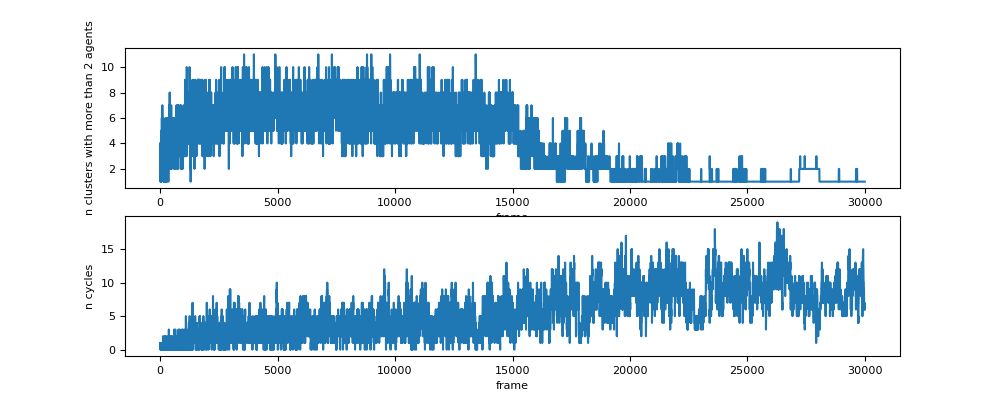

In [240]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (10, 4))
ax.plot(df_graph.frame, df_graph.nClusters)
ax1.plot(df_graph.frame, df_graph.nCycles)
ax.set(xlabel='frame', ylabel = 'n clusters with more than 2 agents')
ax1.set(xlabel='frame', ylabel = 'n cycles')
plt.show()

### dimensionality reduction

In [296]:
from sklearn.preprocessing import StandardScaler
x = df_graph.iloc[:, 1:].values # 1: to skip the frame column
x = StandardScaler().fit_transform(x) # normalizing the features
x = x/np.std(x)
print(np.mean(x), np.std(x))
normalised_dataset = pd.DataFrame(x, columns=label[1:])
normalised_dataset

4.799364949398318e-17 0.999999999999999


,nClusters,nCycles,degree_0,degree_1,degree_2,degree_3,degree_4,degree_5,degree_6,degree_7,...,dim_cycles_40,dim_cycles_41,dim_cycles_42,dim_cycles_43,dim_cycles_44,dim_cycles_45,dim_cycles_46,dim_cycles_47,dim_cycles_48,dim_cycles_49
0,0.034490,-1.901738,0.0,-0.485818,-3.066215,-2.372822,-1.050844,-0.243858,-0.02579,0.0,...,-0.076606,-0.039122,-0.03363,-0.028253,0.0,0.0,0.0,0.0,0.0,0.0
1,0.034490,-1.901738,0.0,-0.485818,-3.066215,-2.372822,-1.050844,-0.243858,-0.02579,0.0,...,-0.076606,-0.039122,-0.03363,-0.028253,0.0,0.0,0.0,0.0,0.0,0.0
2,0.034490,-1.901738,0.0,-0.485818,-3.066215,-2.372822,-1.050844,-0.243858,-0.02579,0.0,...,-0.076606,-0.039122,-0.03363,-0.028253,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.507803,-1.901738,0.0,-1.023843,-3.240166,-2.372822,-1.050844,-0.243858,-0.02579,0.0,...,-0.076606,-0.039122,-0.03363,-0.028253,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.507803,-1.901738,0.0,-0.754830,-3.414118,-2.123994,-1.050844,-0.243858,-0.02579,0.0,...,-0.076606,-0.039122,-0.03363,-0.028253,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-1.592390,0.096922,0.0,-1.292855,1.804428,0.861940,-1.050844,-0.243858,-0.02579,0.0,...,-0.076606,-0.039122,-0.03363,-0.028253,0.0,0.0,0.0,0.0,0.0,0.0
29996,-1.592390,0.096922,0.0,-1.292855,1.804428,0.861940,-1.050844,-0.243858,-0.02579,0.0,...,-0.076606,-0.039122,-0.03363,-0.028253,0.0,0.0,0.0,0.0,0.0,0.0
29997,-1.592390,0.096922,0.0,-1.292855,1.804428,0.861940,-1.050844,-0.243858,-0.02579,0.0,...,-0.076606,-0.039122,-0.03363,-0.028253,0.0,0.0,0.0,0.0,0.0,0.0
29998,-1.592390,0.096922,0.0,-1.292855,1.804428,0.861940,-1.050844,-0.243858,-0.02579,0.0,...,-0.076606,-0.039122,-0.03363,-0.028253,0.0,0.0,0.0,0.0,0.0,0.0


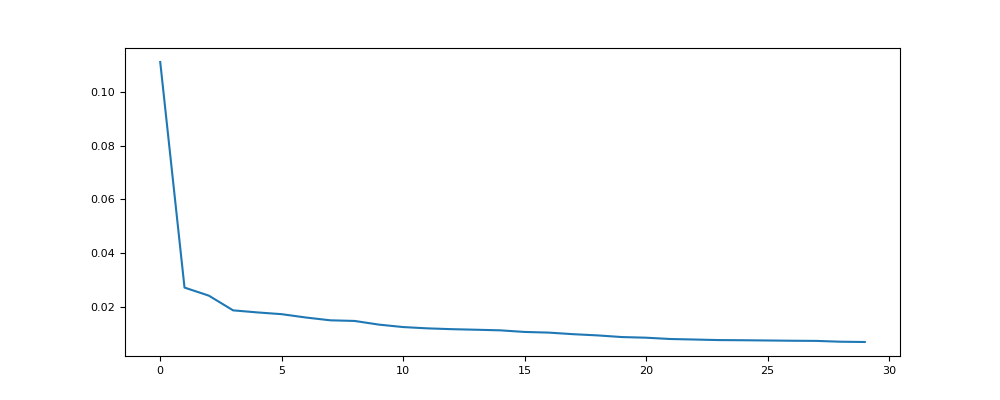

In [297]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
p_components = pca.fit_transform(x)
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(pca.explained_variance_ratio_)
plt.show()

In [365]:
# choose the number of components that explain 95% of the variance
pca = PCA(n_components=3)
p_components = pca.fit_transform(x)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print(p_components.shape)
principal_df = pd.DataFrame(data = p_components, columns = ['pc1', 'pc2', 'pc3'])
display(principal_df.head())

Explained variation per principal component: [0.11122022 0.0271133  0.02410659]
(30000, 3)


,pc1,pc2,pc3
0,-5.677158,-4.215432,-0.210011
1,-5.677158,-4.215432,-0.210011
2,-5.677158,-4.215432,-0.210011
3,-5.030358,-4.115109,-0.197328
4,-5.115598,-4.118821,-0.163950


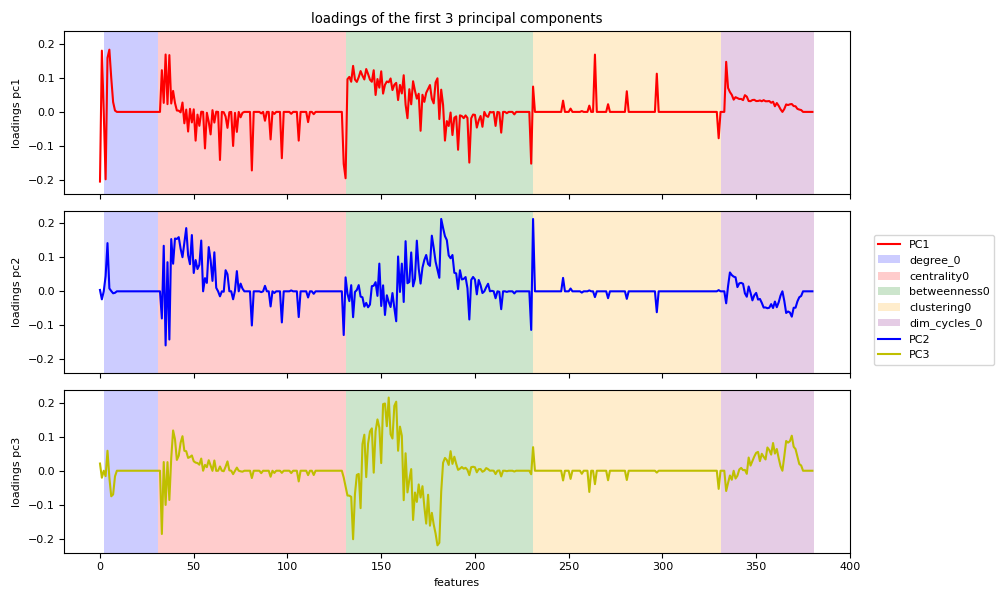

In [364]:
loadings = pca.transform(np.eye(x.shape[1]))
fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize = (10, 6), sharex=True, sharey=True)
ax.plot(loadings[:, 0], 'r', label = 'PC1')
ax1.plot(loadings[:, 1], 'b', label = 'PC2')
ax2.plot(loadings[:, 2], 'y', label = 'PC3')
# Define the regions and colors
regions = [(id_degree[0], id_degree[1]+1, 'blue'), (id_centrality[0], id_centrality[1]+1, 'red'), (id_betweenness[0], id_betweenness[1]+1, 'green'), (id_clustering[0], id_clustering[1]+1, 'orange'), (id_dim_cycles[0], id_dim_cycles[1]+1, 'purple')]
# Plot background colors based on regions
for region in regions:
    ax.axvspan(region[0]-1, region[1]-1, facecolor = region[2], alpha=0.2, label = label[region[0]])
    ax1.axvspan(region[0]-1, region[1]-1, facecolor = region[2], alpha=0.2)
    ax2.axvspan(region[0]-1, region[1]-1, facecolor = region[2], alpha=0.2)
ax.set(ylabel = 'loadings pc1', title = 'loadings of the first 3 principal components')
ax1.set(ylabel = 'loadings pc2')
ax2.set(ylabel = 'loadings pc3', xlabel = 'features')
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.85)
plt.savefig(f'{res_path}/loadings.pdf', format="pdf", bbox_inches='tight')
plt.show()

Explained variation per principal component: [0.11122022 0.02711331 0.02410697]
(30000, 3)


,pc1,pc2,pc3
0,-5.677158,-4.216484,-0.201489
1,-5.677158,-4.216484,-0.201489
2,-5.677158,-4.216484,-0.201489
3,-5.030358,-4.116247,-0.189531
4,-5.115598,-4.119920,-0.156751


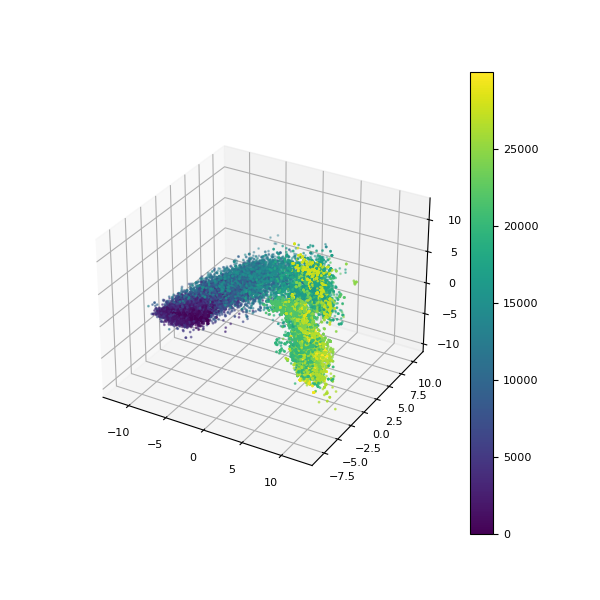

In [308]:

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
# 3d scatter plot
scatterplot = ax.scatter(principal_df['pc1'], principal_df['pc2'], principal_df['pc3'], c = frames, cmap = 'viridis', s = 1)
ax.grid()

"""
# save to gif
import imageio
images = []
for n in range(0, 250):
    if n >= 5:
        ax.azim = ax.azim+1.1
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    images.append(image.reshape(600, 600, 3)) ## 
imageio.mimsave('test.gif', images)
"""

fig.colorbar(scatterplot, ax=ax)
plt.show()

In [300]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(x)
df_result = pd.DataFrame()
df_result['tsne0'] = tsne_results[:,0]
df_result['tsne1'] = tsne_results[:,1]

/Users/matteoscandola/miniconda3/envs/pyenv3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/matteoscandola/miniconda3/envs/pyenv3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.015s...
[t-SNE] Computed neighbors for 30000 samples in 18.974s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for s

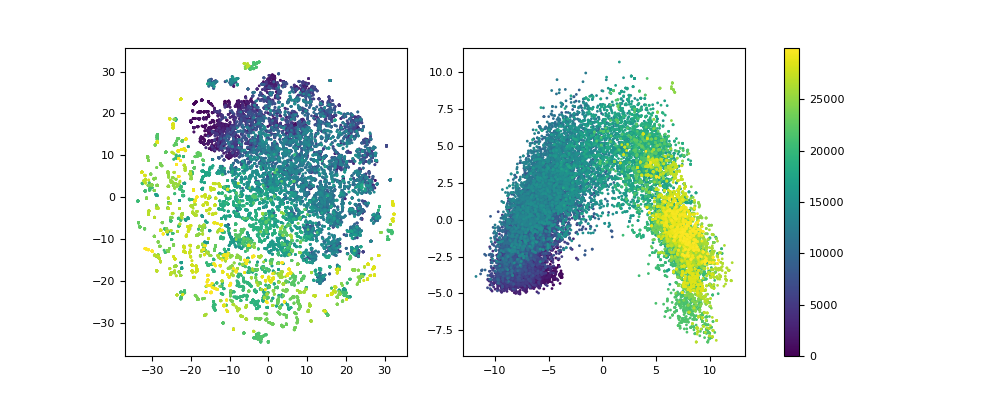

In [301]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
scatterplot = axs[0].scatter(df_result['tsne0'], df_result['tsne1'], c = frames, cmap = 'viridis', s = 1)
axs[1].scatter(principal_df['pc1'], principal_df['pc2'], c = frames, cmap = 'viridis', s = 1)
fig.colorbar(scatterplot, ax = axs)
plt.show()

# coordination number analysis

In [ ]:
@joblib.delayed
def rdf_frame(frame, COORDS, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)
    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        a = kd.query_ball_point(coords, r + 20)
        b = kd.query_ball_point(coords, r)
        n1 = 0
        for j in a:
            n1 += len(j) - 1
        n2 = 0
        for j in b:
            n2 += len(j) - 1
        avg_n[i] = n1/len(a) - n2/len(b)
    rdf = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return rdf


def get_rdf(run_analysis_verb, nFrames, trajs, rList, dr, rho):
    print(trajs)
    if trajs == "raw":
        trajectories = rawTrajs
    elif trajs == "smooth":
        trajectories = smoothTrajs
    else:
        raise ValueError("trajs must be 'raw' or 'smooth'")
     
    if run_analysis_verb:
        COORDS = np.array(trajectories.loc[:, ["x","y"]])
        parallel = joblib.Parallel(n_jobs = -2)
        rdf = parallel(
            rdf_frame(frame, COORDS, rList, dr, rho)
            for frame in tqdm(range(nFrames))
        )
        rdf = np.array(rdf)
        rdf_df = pd.DataFrame(rdf)
        # string columns for parquet filetype
        rdf_df.columns = [f"{r}" for r in rList]
        rdf_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_{trajs}.parquet")

    elif not run_analysis_verb :
        try:
            rdf = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_{trajs}.parquet"))
        except: 
            raise ValueError("rdf data not found. Run analysis verbosely first.")
    else: 
        raise ValueError("run_analysis_verb must be True or False")
    return rdf

In [ ]:
dr = 5
rDisk = 822/2
rList = np.arange(0, 2*rDisk, 1)
rho = nDrops/(np.pi*rDisk**2) # nDrops - 1 !???

print("RDF - Raw Trajectories")
rdf_raw = get_rdf(True, 200, "raw", rList, dr, rho)
#print("RDF - Smooth Trajectories")
#rdf_smooth = get_rdf(run_analysis_verb, nFrames, "smooth", rList, dr, rho)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))
ax.plot(rdf_raw[0])
plt.show()

# CHECK BALLISTIC REGIME BETWEEN 0-1 S - FOR SMOOTH TRAJECTORIES

note that ballistic motion msd has pw exponent 2 !!!

In [ ]:
x = np.arange(0, 10000, 0.1)
y = 10*x + 2*x**2
# compute msd
max_lagtime = 1000
msd = np.zeros(max_lagtime-1)
for lagtime in range(1, max_lagtime):
    msd[lagtime-1] = np.mean((y[lagtime:] - y[:-lagtime])**2 + (x[lagtime:] - x[:-lagtime])**2)
# fit msd with power law
def power_law(x, a, b):
    return a*x**b
popt, pcov = curve_fit(power_law, np.arange(1, max_lagtime), msd, p0 = (1, 1))
print(f"fit parameters: {popt}")

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.plot(np.arange(1, max_lagtime), msd)
ax.set(xlabel="lagtime", ylabel="msd", title = "MSD of a parabola")
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True, linestyle='-', color = '0.75')
plt.show()

In [ ]:
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered
#x = np.array(imsd[1:].index)
x = np.arange(1., 100.1, .1)
imsd, fit, pw_exp = get_imsd(smoothTrajs, pxDimension, fps, maxLagtime, nDrops)

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 4))
ax.plot(imsd.index, imsd, '.',  markersize = 1)
ax.plot(imsd[:1].index, fit_ball.T, linewidth = 1)
ax.plot(imsd[1:].index, fit.T, linewidth = 1)
ax.set(xlabel="lag time [s]", ylabel="MSD [px$^2$]", xscale = "log", yscale = "log", xlim=(0.01, 10))
ax.grid(True, linestyle='-', color = '0.75')

ax1.errorbar(np.arange(0, nDrops, 1), pw_exp_ball[:, 0, 1], yerr = pw_exp_ball[:, 1, 0], fmt = '.', markersize = 5, label = "ballistic")
ax1.errorbar(np.arange(0, nDrops, 1), pw_exp[:, 0, 1], yerr = pw_exp_ball[:, 1, 0], fmt = '.', markersize = 5, label = "diffusive")
ax1.set(xlabel="Droplet ID", ylabel="Pw exponent")
ax1.grid(True, linestyle='-', color = '0.75')
ax1.legend()
plt.tight_layout()
plt.show()

In [ ]:
MSD_b, MSD_r, diffusive_results, ballistic_results = get_emsd(imsd, x, red_particle_idx, nDrops)
fit_b_ball, pw_exp_b_ball = ballistic_results["fit_b"], ballistic_results["pw_exp_b"]
fit_b_diff, pw_exp_b_diff = diffusive_results["fit_b"], diffusive_results["pw_exp_b"]
fit_r_ball, pw_exp_r_ball = ballistic_results["fit_r"], ballistic_results["pw_exp_r"]
fit_r_diff, pw_exp_r_diff = diffusive_results["fit_r"], diffusive_results["pw_exp_r"]

In [ ]:
a_ball = [round(pw_exp_b_ball[0, 1], 3), round(pw_exp_b_ball[1, 1], 3)]
b_ball = [round(pw_exp_r_ball[0, 1], 3), round(pw_exp_r_ball[1, 1], 3)]
print(f"Smooth trajs - Ballistic - Blue Particles: {a_ball[0]} ± {a_ball[1]}, Red Particle: {b_ball[0]} ± {b_ball[1]}")

a_diff = [round(pw_exp_b_diff[0, 1], 3), round(pw_exp_b_diff[1, 1], 3)]
b_diff = [round(pw_exp_r_diff[0, 1], 3), round(pw_exp_r_diff[1, 1], 3)]
print(f"Smooth trajs - Diffusive - Blue Particles: {a_diff[0]} ± {a_diff[1]}, Red Particle: {b_diff[0]} ± {b_diff[1]}")

fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(imsd.index, MSD_b[0], 'b-', label = "Blue particles") 
ax.plot(imsd[1:].index, fit_b_diff, 'b--', label = f"Diffusive Region: {a_diff[0]} ± {a_diff[1]}")
ax.plot(imsd[:1].index, fit_b_ball, 'b:', label = f"Ballistic Region: {a_ball[0]} ± {a_ball[1]}")
ax.fill_between(imsd.index, MSD_b[0] - MSD_b[1], MSD_b[0] + MSD_b[1], alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax.plot(imsd.index, MSD_r, 'r-', label = "Red particle")
ax.plot(imsd[1:].index, fit_r_diff, 'r--', label = f"Diffusive Region: {b_diff[0]} ± {b_diff[1]}")
ax.plot(imsd[:1].index, fit_r_ball, 'r:', label = f"Ballistic Region: {b_ball[0]} ± {b_ball[1]}")
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',   
        xlabel = 'lag time $t$ [s]', title = "EMSD - Smooth Trajectories")
ax.legend()
ax.grid()
plt.savefig(f"./{res_path}/mean_squared_displacement/ballistic_region/EMSD_smoothTrajs.png", bbox_inches = 'tight')
plt.show()

# DIMENSION OF DROPLETS ANALYSIS

In [5]:
rawTrajs

,y,x,area,prob,frame,r,particle,color
0,312.065010,290.043977,1569,0.956433,0,22.347891,0,#8B0E71
27,360.432955,172.658439,1499,0.947308,0,21.843684,1,#53BF7C
28,294.998729,703.315121,1574,0.946646,0,22.383471,2,#3706D8
29,589.972418,513.207184,1559,0.946499,0,22.276560,3,#5C524E
30,245.110956,695.208653,1433,0.945830,0,21.357389,4,#440066
...,...,...,...,...,...,...,...,...
1499995,522.619654,205.262056,1099,0.942800,29999,18.703544,45,#F94F03
1499966,447.515152,190.640955,1089,0.954060,29999,18.618256,46,#E7914C
1499953,343.507246,595.924819,1104,0.959850,29999,18.746043,47,#0F87F1
1499989,322.577477,561.790991,1110,0.945935,29999,18.796914,48,#7F8499


In [3]:
mean_wind = rawTrajs.groupby("frame").mean().r

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(mean_wind.index/10, mean_wind)
ax.set(xlabel = "Time [s]", ylabel = "r [px]", title = "Droplets mean radius")
ax.grid(True, linestyle='-', color = '0.75')
if save_verb: plt.savefig(res_path + "/dimension_analysis/mean_radius.png", bbox_inches='tight')
if 0: plt.savefig(res_path + "/dimension_analysis/mean_radius.pdf", format="pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [515]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
temp = rawTrajs[rawTrajs.particle == red_particle_idx]
temp_d = temp.r#.rolling(window = 100).mean()
ax.plot(temp.frame/10, temp_d, 'r-', zorder = 10)
for i in range(nDrops):
    if i != red_particle_idx:
        temp = rawTrajs[rawTrajs.particle == i]
        temp_d = temp.r#.rolling(window = 100).mean()
        ax.plot(temp.frame.values.astype(int)/10, temp_d, 'b-', alpha = 0.4, linewidth = 0.5, zorder = 0)
ax.set(xlabel = "Time [s]", ylabel = "r [px]", title = "Droplet radius moving averaged over 100 frames")
ax.grid()
ax.legend(["Red droplet", "Blue droplets"])
if save_verb: plt.savefig(res_path + "/dimension_analysis/radius_mov_avg_100.png", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

## windowed radius vs thingz

In [498]:
# mean and std droplet diameter per frame
# windowed ?
nFrames =  max(rawTrajs.frame) + 1
print(nFrames)
# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")

mean_r_wind = np.zeros(nSteps)
for i, start in enumerate(startFrames):
    temp = rawTrajs.loc[rawTrajs.frame.between(start, start+window)]
    mean_r_wind[i] = np.nanmean(temp.r.values)

d_wind = np.zeros((nSteps, nDrops))
d_wind_std = np.zeros((nSteps, nDrops))
for i, start in enumerate(startFrames):
    temp = rawTrajs.loc[rawTrajs.frame.between(start, start+window)]
    for j in range(nDrops):
        temp_j = temp.loc[temp.particle == j].r.values
        d_wind[i, j] = np.nanmean(temp_j)
        d_wind_std[i, j] = np.nanstd(temp_j)

30000
window of 320.0 s, stride of 10.0 s
number of steps: 268


In [499]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(startFrames/10, mean_r_wind, 'k--', linewidth = 2, zorder=20)
ax.plot(startFrames/10, d_wind[:, red_particle_idx], 'r-', linewidth = 2, zorder=10)
for i in range(nDrops):
    if i != red_particle_idx:
        ax.plot(startFrames/10, d_wind[:, i], 'b-', zorder=0, alpha = 0.5)
ax.set(xlabel = "Window time [s]", ylabel = "r [px]", title = "Droplet radius by window time")
ax.grid()
ax.legend(["Mean", "Red droplet", "Blue droplets"])
if save_verb: plt.savefig(res_path + "/dimension_analysis/radius_wind.png", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

### vs power law exp

In [ ]:
show_verb = False
run_windowed_analysis = True
plot_verb = False
animated_plot_verb = False
print(f"MSD Analysis: show_verb = {show_verb}, run_windowed_analysis = {run_windowed_analysis}, animated_plot_verb = {animated_plot_verb}")

%run ./analysis_modules/msd.ipynb

In [ ]:
individual_pw_law = pw_exp_wind[:, :, 0, 1]
ensemble_pw_lab_b = fit_dict["pw_exp_wind_b"][:, 0, 1]
ensemble_pw_lab_r = fit_dict["pw_exp_wind_r"][:, 0, 1]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(startFrames/10, individual_pw_law[:, red_particle_idx], 'r-', zorder = 10)
for i in range(nDrops):
    if i != red_particle_idx:
        ax.plot(startFrames/10, individual_pw_law[:, i], 'b-', zorder=0, alpha = 0.5, linewidth = 0.5)
ax.set(xlabel = "Window time [s]", ylabel = r'$\beta$', title = "Droplet power law exponent by window time")
ax.grid()
ax.legend(["Red droplet", "Blue droplets"])
if save_verb: plt.savefig(res_path + "/mean_squared_displacement/windowed_analysis/beta_wind_hough.png", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.scatter(d_wind[:, i], individual_pw_law[:, red_particle_idx], s= 5, c = startFrames/10, marker = 'o', cmap = cm.Reds, zorder = 10)
for i in range(nDrops):
    if i != red_particle_idx:
        scatter = ax.scatter(d_wind[:, i], individual_pw_law[:, i], s= 5, c = startFrames/10, marker = 'o', cmap = cm.Blues, zorder = 0)
ax.set(ylabel = r"$\beta$", xlabel = "r [px]", title = "Windowed Power law exponent vs droplet radius")
ax.grid()
fig.legend(*scatter.legend_elements(), title = "Window Time", fontsize = 8, loc=7)
if save_verb: plt.savefig(res_path + "/radius_scatterplots/beta_vs_radius_wind_hough.png", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
scatter = ax.scatter(mean_r_wind, ensemble_pw_lab_b, s= 5, c = startFrames/10, marker = 'o', cmap = cm.Blues)
ax.scatter(mean_r_wind, ensemble_pw_lab_r, s= 5, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax.set(ylabel = r"$\beta$", xlabel = "r [px]", title = "Windowed ensamble Power law exponent vs mean droplet radius")
ax.grid()
fig.legend(*scatter.legend_elements(), title = "Window Time", fontsize = 8, loc=7)
if save_verb: plt.savefig(res_path + "/radius_scatterplots/beta_vs_mean_radius_wind_hough.png", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

### vs Velocity Variance

In [ ]:
show_verb = False
run_windowed_analysis = True
overwrite = False
animated_plot_verb = False
plot_verb = False

print(f"Velocity Autocorrelation Analysis: show_verb = {show_verb}, run_windowed_analysis = {run_windowed_analysis}, animated_plot_verb = {animated_plot_verb}")
%run ./analysis_modules/velocity_autocorrelation.ipynb

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5), sharex = True, sharey = True)
scatter = ax.scatter(vacf_b_wind["0"], mean_r_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter1 = ax.scatter(vacf_r_wind["0"], mean_r_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax.set(title = "Raw Trajs", xlabel = r"$\sigma_v^2$", ylabel = "d [px]" )
ax.grid(True, linestyle='-', color = '0.75')

scatter2 = ax1.scatter(vacf_b_wind_smooth["0"], mean_r_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter3 = ax1.scatter(vacf_r_wind_smooth["0"], mean_r_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax1.set(title = "Smooth Trajs", xlabel = r"$\sigma_v^2$", ylabel = "d [px]")
ax1.grid(True, linestyle='-', color = '0.75')

fig.suptitle("Velocity Variance vs. Mean Radius")
fig.legend(*scatter3.legend_elements(), title = "Window Time", fontsize = 8, loc = 7)
fig.tight_layout()
fig.subplots_adjust(right=1)
if save_verb: plt.savefig(res_path + '/radius_scatterplots/v_variance.png', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

### vs Effective Temperature from velocity distribution

In [ ]:
show_verb = False
animated_plot_verb = False
plot_verb = False
save_verb = False
v_step = 10
print(f"Speed and Turning Angles Analysis: show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
%run ./analysis_modules/velocity_distr.ipynb

In [ ]:
eff_T_speed_b = blue_fit_wind[:, 0]
eff_T_speed_b_sigma = blue_fit_wind[:, 1]
eff_T_speed_r = red_fit_wind[:, 0]
eff_T_speed_r_sigma = red_fit_wind[:, 1]

eff_T_speed_b_smooth = blue_fit_wind_smooth[:, 0]
eff_T_speed_b_sigma_smooth = blue_fit_wind_smooth[:, 1]
eff_T_speed_r_smooth = red_fit_wind_smooth[:, 0]
eff_T_speed_r_sigma_smooth = red_fit_wind_smooth[:, 1]

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5), sharex = True, sharey = True)
scatter = ax.scatter(eff_T_speed_b, mean_r_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter1 = ax.scatter(eff_T_speed_r, mean_r_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax.set(title = "Raw Trajs", xlabel = r"$T_{eff} \; [??]$", ylabel = "d [px]")
ax.grid(True, linestyle='-', color = '0.75')

scatter2 = ax1.scatter(eff_T_speed_b_smooth, mean_r_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter3 = ax1.scatter(eff_T_speed_r_smooth, mean_r_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax1.set(title = "Smooth Trajs", xlabel = r"$T_{eff} \; [??]$", ylabel = "d [px]")
ax1.grid(True, linestyle='-', color = '0.75')

fig.suptitle("Effective Temperature vs. Mean Radius")
fig.legend(*scatter3.legend_elements(), title = "Window Time", fontsize = 8, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=1)
plt.tight_layout()
if save_verb: plt.savefig(res_path + '/radius_scatterplots/eff_T.png', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# 3 body

sigma direi di usare il diametro, per b direi [0 - 3 sigma] a step non superiori a 0.2 sigma.

In [ ]:
@njit
def compute_bin(x, bin_edges):
    # assuming uniform bins for now
    n = bin_edges.shape[0] - 1
    a_min = bin_edges[0]
    a_max = bin_edges[-1]
    # special case to mirror NumPy behavior for last bin
    if x == a_max:
        return n - 1 # a_max always in last bin
    bin = int(n * (x - a_min) / (a_max - a_min))
    if bin < 0 or bin >= n:
        return None
    else:
        return bin
@njit
def numba_histogram(a, bin_edges, weights):
    hist = np.zeros((len(bin_edges)-1,), dtype=np.intp)
    for ind, x in enumerate(a):
        bin = compute_bin(x, bin_edges)
        if bin is not None:
            hist[int(bin)] += weights[ind]
    return hist

@njit
def numba_mean_ax0(a):
    res = []
    for i in prange(a.shape[1]):
        res.append(a[:, i].mean())
    return np.array(res)



# this doesn't work
@njit(parallel = True)
def three_body_frame(coords, bList, sigma, hist_bins):
    """
    Computes the three body distribution for a single frame
    coords : array of shape (nDrops, 3)
        The coordinates of the drops
    bList : array of shape (nB)
        The b values to compute the three body distribution for
    sigma : float   
        The standard deviation of the gaussian used to weight the three body distribution
    hist_bins : array of shape (nBins)
        The bins to compute the three body distribution for
    Returns 
    ------- 
    mean_3_body : array of shape (nB, nBins)
        The mean three body distribution for each b value
    """
    res = np.ones((len(bList), len(hist_bins)-1))
    three_body = np.ones((nDrops, len(hist_bins)-1))
    angles = np.ones(int((nDrops-1)*(nDrops-2)/2))
    gauss_weights = np.zeros(int((nDrops-1)*(nDrops-2)/2))
    for b_ind in prange(len(bList)):
        b = bList[b_ind]
        for i in prange(nDrops):
            count = 0
            r_i = coords[i]
            for j in range(nDrops):
                if i == j:
                    continue
                r_ij = coords[j] - r_i
                for k in range(j+1, nDrops):
                    if k == i:
                        continue
                    r_ik = coords[k] - r_i
                    angles[count] = np.arccos(np.dot(r_ij, r_ik) / (np.linalg.norm(r_ij) * np.linalg.norm(r_ik)))
                    gauss_weights[count] = np.exp(-0.5*((np.linalg.norm(r_ij)-b)/sigma)**2) * np.exp(-0.5*((np.linalg.norm(r_ik)-b)/sigma)**2)
                    count += 1
            three_body[i] = numba_histogram(angles, hist_bins, gauss_weights)
        res[b_ind] = numba_mean_ax0(three_body)
    return res

@njit(parallel = True)
def three_body_frame_modified(coords, bList, sigma, hist_bins):
    angles = np.ones((len(bList), nDrops, int((nDrops-1)*(nDrops-2)/2)))
    gauss_weights = np.ones((len(bList), nDrops, int((nDrops-1)*(nDrops-2)/2)))
    for b_ind in prange(len(bList)):
        b = bList[b_ind]
        for i in range(nDrops):
            count = 0
            r_i = coords[i]
            for j in range(nDrops):
                if i == j:
                    continue
                r_ij = coords[j] - r_i
                for k in range(j+1, nDrops):
                    if k == i:
                        continue
                    r_ik = coords[k] - r_i
                    angles[b_ind, i, count] = np.arccos(np.dot(r_ij, r_ik) / (np.linalg.norm(r_ij) * np.linalg.norm(r_ik)))
                    gauss_weights[b_ind, i, count] = np.exp(-0.5*((np.linalg.norm(r_ij)-b)/sigma)**2) * np.exp(-0.5*((np.linalg.norm(r_ik)-b)/sigma)**2)
                    count += 1
    return angles, gauss_weights

In [ ]:
# test 1 --> doesn't work, problem in three_body_frame
if 0:
    COORDS = np.array(rawTrajs.loc[:,["x","y"]])
    sigma = 38
    bList = np.arange(0, 3*sigma, .2)
    print("bList length: ", bList.shape[0])
    frames = np.arange(0, 30000, 1, dtype = int)
    nFrames = len(frames)

    hist_bins = np.arange(0, np.pi, np.pi/100)
    mean_3_body = np.zeros((nFrames, len(bList), len(hist_bins)-1))

    for frame_ind in tqdm(range(nFrames)):
        mean_3_body[frame_ind] = three_body_frame(COORDS[frames[frame_ind]:frames[frame_ind]+50], bList, sigma, hist_bins)
            
    # save to txt frames, bList and hist bins
    if 1:
        np.savetxt(f"./{analysis_data_path}/3_body/frames.txt", frames)
        np.savetxt(f"./{analysis_data_path}/3_body/bList.txt", bList)
        np.savetxt(f"./{analysis_data_path}/3_body/hist_bins.txt", hist_bins)
        for i, b in enumerate(bList):
            temp = pd.DataFrame(mean_3_body[:, i])
            temp.columns = [str(i) for i in temp.columns]
            temp.to_parquet(f"./{analysis_data_path}/3_body/mean_3_body_{b}.parquet")
else:
    frames = np.loadtxt(f"./{analysis_data_path}/3_body/frames.txt").astype(int)
    nFrames = len(frames)
    bList = np.loadtxt(f"./{analysis_data_path}/3_body/bList.txt")#.astype(int)
    hist_bins = np.loadtxt(f"./{analysis_data_path}/3_body/hist_bins.txt")
    mean_3_body = np.zeros((nFrames, len(bList), len(hist_bins)-1))
    for i, b in enumerate(bList):
        mean_3_body[:, i] = pd.read_parquet(f"./{analysis_data_path}/3_body/mean_3_body_{b}.parquet").values

In [ ]:
# test 2 --> seems to work with three_body_frame_modified function
COORDS = np.array(rawTrajs.loc[:,["x","y"]])
sigma = 38
# for thest_3body.parquet
#bList = np.arange(0, 3*sigma + 1, 3*sigma/50) # step 0.2 too little --> 448 hours to complete 30k frames

# for thest_3body_2.parquet
bList = np.arange(0, 300, 300/50) 
print("bList length: ", bList.shape[0])
hist_bins = np.arange(0, np.pi, np.pi/100)
hist_centers = (hist_bins[:-1] + hist_bins[1:])/2
# frames = np.arange(0, 30000, 10) for test
if 0:
    counts = np.zeros((len(frames), len(bList), nDrops, len(hist_bins)-1))
    for frame_ind in tqdm(range(len(frames))):
        test_ang, test_weights = three_body_frame_modified(COORDS[frames[frame_ind]:frames[frame_ind]+50], bList, sigma, hist_bins)
        for b_ind in range(len(bList)):
            for i in range(nDrops):
                counts[frame_ind, b_ind, i] = np.histogram(test_ang[b_ind, i], bins = hist_bins, weights = test_weights[b_ind, i])[0]
    test_reshape = counts.reshape((len(bList)*nDrops*(len(hist_bins)-1), len(frames)))
    test_df = pd.DataFrame(test_reshape)
    test_df.columns = frames.astype(str)
    test_df.to_parquet(f"./{analysis_data_path}/3_body/test_3body.parquet")
else:
    try: 
        print("Importing data...")
        test_df = pd.read_parquet(f"./{analysis_data_path}/3_body/test_3body2.parquet")
        frames = test_df.columns.astype(int)
        counts = np.array(test_df).reshape((len(frames), len(bList), nDrops, len(hist_bins)-1))
        mean_3_body = np.mean(counts, axis = 2)
        mean_3_body_norm = mean_3_body / mean_3_body.sum(axis=2).reshape(mean_3_body.shape[0], mean_3_body.shape[1], 1)
    except:
        raise Exception("File not found")

In [ ]:
for frame in range(0, len(frames), 30):
    fig, ax = plt.subplots(1, 1, figsize = (10, 4))
    anim_running = True
    def onClick(event):
        global anim_running
        if anim_running:
            ani.event_source.stop()
            anim_running = False
        else:
            ani.event_source.start()
            anim_running = True

    plot = ax.plot(hist_centers, mean_3_body_norm[frame, 0], color = "black")[0]
    ax.set(ylabel = "pdf", xlabel = r"$\theta$")
    title = ax.set_title(f"Three body metric at frame = {frame}, b: {np.round(bList[0],2)}")

    def animate_func(i):
        plot.set_ydata(mean_3_body_norm[frame, i])
        title.set_text(f"Three body metric at frame = {frame}, b: {np.round(bList[i],2)}")
        return plot

    fig.canvas.mpl_connect('button_press_event', onClick)
    ani = matplotlib.animation.FuncAnimation(fig, animate_func, mean_3_body_norm.shape[1], interval = 300)
    ani.save(f"./hough_results/3body/test2/frame{frames[frame]}.mp4", fps = 5)
    plt.close()

In [ ]:
"""
frame = 10
fig, ax = plt.subplots(1, 1)
im = ax.imshow(counts[frame])
ax.set(ylabel="b", xlabel="angle", title=f"frame {frame}")
ax.set_xticklabels([f"$\pi$ /{i}" for i in range(10)])
ax.set_yticklabels(bList.astype(int))
fig.colorbar(im, ax=ax)
ax.set_aspect(1.8)
plt.show()
"""

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
anim_running = True
def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

im = ax.imshow(mean_3_body_norm[0])
ax.set(ylabel = "b", xlabel = "angle")
title = ax.set_title(f"frame: {0}")

ax.set_xticks(np.arange(0, len(hist_bins), 10))
ax.set_xticklabels(np.round(hist_bins,1)[::10])
ax.set_yticks(np.arange(0, len(bList), 10))
ax.set_yticklabels(bList.astype(int)[::10])
ax.set_aspect(2)
fig.colorbar(im, ax=ax)

def animate_func(i):
    im.set_array(mean_3_body_norm[i])
    title.set_text(f"frame: {frames[i]}")
    return [im]

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate_func, mean_3_body_norm.shape[0], interval = 100)
ani.save(f'./{res_path}/3body/3_body_mean_test_norm.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close()

# CUMULATIVE TURNING ANGLES

In [ ]:
nFrames = max(smoothTrajs.frame)

blueTrajs, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)
theta_blue = np.zeros((nDrops-1, nFrames-1))
for i in range(nDrops-1):
    theta_blue[i] = ys.turning_angles_ensemble([blueTrajs[i]], centered = True, accumulate = False)
theta_red = ys.turning_angles_ensemble(redTraj, centered = True, accumulate = False)

# cumulative turning angles
theta_blue_cum = np.cumsum(theta_blue, axis=1)
theta_red_cum = np.cumsum(theta_red)

fig, (ax,ax1) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax.plot(np.arange(0, nFrames-1)/10, np.mean(theta_blue_cum, axis = 0), 'b-', label = "Blue droplets")
ax.set(title = "Cumulative turning angles", ylabel = r"$\theta$ [rad]")
ax.grid(True, linestyle='-', color = '0.75')
ax.legend(loc = "upper left")
ax1.plot(np.arange(0, nFrames-1)/10, theta_red_cum, 'r-', label = "Red droplet")
ax1.set(xlabel = "Time [s]", ylabel = r"$\theta$ [rad]")
ax1.grid(True, linestyle='-', color = '0.75')
ax1.legend(loc = "upper left")
plt.tight_layout()
plt.savefig(f"./{res_path}/turning_angles/cumulative_turning_angles.png", bbox_inches = "tight")
plt.show()

In [ ]:
ax.get_legend_handles_labels()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
blue = ax.plot(np.arange(0, nFrames-1)/10, theta_blue_cum.T, linewidth = 0.5, alpha = 0.5, color = 'b')
red = ax.plot(np.arange(0, nFrames-1)/10, theta_red_cum, 'r-')
ax.set(title = "Individual cumulative turning angles", ylabel = r"$\theta$ [rad]", xlabel = "Time [s]")
ax.grid(True, linestyle='-', color = '0.75')
plt.savefig(f"./{res_path}/turning_angles/individual_cumulative_turning_angles.png", bbox_inches = "tight")
plt.show()

In [ ]:
blueTrajs, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)
theta_blue = np.zeros((nDrops-1, nFrames))
for i in range(nDrops-1):
    theta_blue[i] = ys.turning_angles_ensemble([blueTrajs[i]], centered = True, accumulate = True)
theta_red = ys.turning_angles_ensemble(redTraj, centered = True, accumulate = True)

fig, (ax,ax1) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax.plot(np.arange(0, nFrames)/10, np.mean(theta_blue, axis = 0), 'b-', label = "Blue droplets")
ax.set(title = "Cumulative turning angles - with accumulate = True", ylabel = r"$\theta$ [rad]")
ax.grid(True, linestyle='-', color = '0.75')
ax.legend(loc = "upper left")
ax1.plot(np.arange(0, nFrames)/10, theta_red, 'r-', label = "Red droplet")
ax1.set(xlabel = "Time [s]", ylabel = r"$\theta$ [rad]")
ax1.grid(True, linestyle='-', color = '0.75')
ax1.legend(loc = "upper left")
plt.tight_layout()
plt.show()

# MEAN SQUARED ANGULAR DIFFERENCE

In [ ]:
def get_msad(maxLagtime, r):
    current_msd = np.empty(maxLagtime)
    for lag_ in prange(1, maxLagtime + 1):
        x_ = np.sum(r[lag_:] * r[:-lag_], axis=1) / (np.linalg.norm(r[lag_:], axis=1)*np.linalg.norm(r[:-lag_], axis=1))
        temp = np.arccos( np.clip(x_, -1, 1) )
        current_msd[lag_ - 1] = np.mean(temp)
    return current_msd

In [ ]:
# mean squared angular displacement 
blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
maxLagtime = 1000
msad = np.empty((len(blueTrajs), maxLagtime))
for i in tqdm(range(len(blueTrajs))):
    r = np.array(blueTrajs[i].r)
    current_msd = get_msad(maxLagtime, r)
    msad[i] = current_msd
msad_b = np.mean(msad, axis=0)
msad_b_std = np.std(msad, axis=0)

msad_r = get_msad(maxLagtime, np.array(redTraj[0].r))

In [ ]:
msad_b.shape

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, maxLagtime+1, 1)/10, msad_b, 'b', label="blue")
ax.plot(np.arange(1, maxLagtime+1, 1)/10, msad_r, 'r', label="red")
ax.legend()
ax.grid()
ax.set(xlabel="lag [s]", ylabel="MSAD ", xscale="log", yscale="log")
plt.show()

# VELOCITY CORRELATION

In [ ]:
@njit(parallel=True, fastmath=True)
def get_corr(velocities, maxLagtime_):
    xx = np.zeros((velocities.shape[0], maxLagtime_))
    yy = np.zeros((velocities.shape[0], maxLagtime_))
    xy = np.zeros((velocities.shape[0], maxLagtime_))
    for i in prange(velocities.shape[0]):
        v = velocities[i]
        xx[i, 0] = np.corrcoef(v[0], v[0])[0, 1]
        yy[i, 0] = np.corrcoef(v[1], v[1])[0, 1]
        xy[i, 0] = np.corrcoef(v[0], v[1])[0, 1]
        
        for lag_ in prange(1, maxLagtime_):
            xx[i, lag_] = np.corrcoef(v[0, :-lag_], v[0, lag_:])[0, 1]
            yy[i, lag_] = np.corrcoef(v[1, :-lag_], v[1, lag_:])[0, 1]
            xy[i, lag_] = np.corrcoef(v[0, :-lag_], v[1, lag_:])[0, 1]
    return xx, yy, xy

def corr_windowed(nSteps, maxLagtime, startFrames, endFrames, trajectories, red_particle_idx, nDrops):
    corr_b = np.zeros((nSteps, 3, maxLagtime))
    corr_std_b = np.zeros((nSteps, 3, maxLagtime))
    corr_r = np.zeros((nSteps, 3, maxLagtime))
    corr_std_r = np.zeros((nSteps, 3, maxLagtime))

    for k in tqdm(range(nSteps)):
        trajs = trajectories.loc[trajectories.frame.between(startFrames[k], endFrames[k])]
        blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, trajs)

        res = np.array(get_corr(get_velocities(blueTrajs), maxLagtime))
        corr_b[k], corr_std_b[k] = res.mean(axis=1), res.std(axis=1)
        
        res = np.array(get_corr(get_velocities(redTraj), maxLagtime))
        corr_r[k], corr_std_r[k] = res.mean(axis=1), res.std(axis=1)

    return corr_b, corr_std_b, corr_r, corr_std_r

In [ ]:
if 0:
    maxLagtime = 300
    corr_b, corr_std_b, corr_r, corr_std_r = corr_windowed(nSteps, maxLagtime, startFrames, endFrames, rawTrajs, red_particle_idx, nDrops)

    windLenght = 10
    polyOrder = 2
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, windLenght, polyOrder)
    corr_b_smooth, corr_std_b_smooth, corr_r_smooth, corr_std_r_smooth = corr_windowed(nSteps, maxLagtime, startFrames, endFrames, smoothTrajs, red_particle_idx, nDrops)
    if 1:
        path = f"./{analysis_data_path}/corr/raw/"
        pd.DataFrame(corr_b[:,0]).to_csv(path+"corr_b_x.csv", index=False)
        pd.DataFrame(corr_b[:,1]).to_csv(path+"corr_b_y.csv", index=False)
        pd.DataFrame(corr_b[:,2]).to_csv(path+"corr_b_xy.csv", index=False)
        pd.DataFrame(corr_std_b[:,0]).to_csv(path+"corr_std_b_x.csv", index=False)
        pd.DataFrame(corr_std_b[:,1]).to_csv(path+"corr_std_b_y.csv", index=False)
        pd.DataFrame(corr_std_b[:,2]).to_csv(path+"corr_std_b_xy.csv", index=False)
        pd.DataFrame(corr_r[:,0]).to_csv(path+"corr_r_x.csv", index=False)
        pd.DataFrame(corr_r[:,1]).to_csv(path+"corr_r_y.csv", index=False)
        pd.DataFrame(corr_r[:,2]).to_csv(path+"corr_r_xy.csv", index=False)
        pd.DataFrame(corr_std_r[:,0]).to_csv(path+"corr_std_r_x.csv", index=False)
        pd.DataFrame(corr_std_r[:,1]).to_csv(path+"corr_std_r_y.csv", index=False)
        pd.DataFrame(corr_std_r[:,2]).to_csv(path+"corr_std_r_xy.csv", index=False)

        path = f"./{analysis_data_path}/corr/smooth/"
        text_file = open(path+"specs.txt", "w")
        n = text_file.write(f'Window size: {windLenght}, polyorder: {polyOrder}')
        text_file.close()

        pd.DataFrame(corr_b_smooth[:,0]).to_csv(path+"corr_b_x.csv", index=False)
        pd.DataFrame(corr_b_smooth[:,1]).to_csv(path+"corr_b_y.csv", index=False)
        pd.DataFrame(corr_b_smooth[:,2]).to_csv(path+"corr_b_xy.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,0]).to_csv(path+"corr_std_b_x.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,1]).to_csv(path+"corr_std_b_y.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,2]).to_csv(path+"corr_std_b_xy.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,0]).to_csv(path+"corr_r_x.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,1]).to_csv(path+"corr_r_y.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,2]).to_csv(path+"corr_r_xy.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,0]).to_csv(path+"corr_std_r_x.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,1]).to_csv(path+"corr_std_r_y.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,2]).to_csv(path+"corr_std_r_xy.csv", index=False)
else:
    maxLagtime = 300
    type_list = ["x", "y", "xy"]
    path = f"./{analysis_data_path}/corr/raw/"
    corr_b = np.zeros((nSteps, 3, maxLagtime))
    corr_b_std = np.zeros((nSteps, 3, maxLagtime))
    corr_r = np.zeros((nSteps, 3, maxLagtime))
    corr_r_std = np.zeros((nSteps, 3, maxLagtime))

    for i in range(3):
        corr_b[:, i] = pd.read_csv(path+f"corr_b_{type_list[i]}.csv").values
        corr_b_std[:, i] = pd.read_csv(path+f"corr_std_b_{type_list[i]}.csv").values
        corr_r[:, i] = pd.read_csv(path+f"corr_r_{type_list[i]}.csv").values
        corr_r_std[:, i] = pd.read_csv(path+f"corr_std_r_{type_list[i]}.csv").values

    path = f"./{analysis_data_path}/corr/smooth/"
    corr_b_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_b_std_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_r_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_r_std_smooth = np.zeros((nSteps, 3, maxLagtime))
    for i in range(3):
        corr_b_smooth[:, i] = pd.read_csv(path+f"corr_b_{type_list[i]}.csv").values
        corr_b_std_smooth[:, i] = pd.read_csv(path+f"corr_std_b_{type_list[i]}.csv").values
        corr_r_smooth[:, i] = pd.read_csv(path+f"corr_r_{type_list[i]}.csv").values
        corr_r_std_smooth[:, i] = pd.read_csv(path+f"corr_std_r_{type_list[i]}.csv").values


In [ ]:
type = "Raw"

if type == "Raw":
    corr_b_plot = corr_b
    corr_r_plot = corr_r

elif type == "Smooth":
    corr_b_plot = corr_b_smooth
    corr_r_plot = corr_r_smooth

else:
    print("Wrong type")

coord_list = ["x", "y", "xy"]

fig = plt.figure(figsize = (8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    title.set_text(f"Velocity autocorrelation - {type} Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    for i in range(3):
        graphs[i].set_ydata(corr_b_plot[step, i])  
        graphs1[i].set_ydata(corr_b_plot[step, i])
    return graphs, graphs1

ax = fig.add_subplot(211)
title = ax.set_title(f"Velocity autocorrelation - {type} Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphs = []
for i in range(3):
    graphs.append(ax.plot(np.arange(0, maxLagtime, 1)/10, corr_b_plot[0, i], label = f"{coord_list[i]}")[0])
ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 10), ylim = (-0.5, 1))
ax.grid()
ax.legend()

ax1 = fig.add_subplot(212)
graphs1 = []
for i in range(3):
    graphs1.append(ax1.plot(np.arange(0, maxLagtime, 1)/10, corr_r_smooth[0, i], label = f"{type_list[i]}")[0])
ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 10), ylim = (-0.5, 1))
ax1.grid()
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if 1:
    ani.save(f'./{res_path}/corr/corr_{type.lower()}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if 0:
    plt.show()
else:
    plt.close()

# ANALYSIS OF WIND PARAMETER ON FILTER

In [ ]:
bin_borders = np.arange(0, 100, .2)
bin_centers = np.arange(0, 100, .2)[:-1] + .2 / 2
bin_borders_turn = np.arange(-np.pi, np.pi + 0.0001, np.pi/50)
bin_centers_turn = bin_borders_turn[:-1] + np.diff(bin_borders_turn) / 2
v_step = 10

windLenList = np.arange(3, 50, 1)
v_b = np.zeros((len(windLenList), len(bin_centers)))
v_r = np.zeros((len(windLenList), len(bin_centers)))
t_b = np.zeros((len(windLenList), len(bin_centers_turn)))
t_r = np.zeros((len(windLenList), len(bin_centers_turn)))
for i in tqdm(range(len((windLenList)))):
    traj = get_smooth_trajs(rawTrajs, nDrops, windLenList[i], 2)
    blue, red = get_trajs(nDrops, red_particle_idx, traj) 
    v_b[i] = np.histogram(ys.speed_ensemble(blue, step = v_step), bin_borders, density=True)[0]
    v_r[i] = np.histogram(ys.speed_ensemble(red, step = v_step), bin_borders, density=True)[0]
    t_b[i] = np.histogram(ys.turning_angles_ensemble(blue, centered = True), bin_borders_turn, density=True)[0]
    t_r[i] = np.histogram(ys.turning_angles_ensemble(red, centered = True), bin_borders_turn, density=True)[0]

v_diff_b = np.zeros(len(windLenList) - 1)
v_diff_r = np.zeros(len(windLenList) - 1)
t_diff_b = np.zeros(len(windLenList) - 1)
t_diff_r = np.zeros(len(windLenList) - 1)
# mean absolute difference between two consecutive windows
for i in range(len(windLenList)-1):
    v_diff_b[i] = np.mean(np.abs(v_b[i] - v_b[i+1]))
    v_diff_r[i] = np.mean(np.abs(v_r[i] - v_r[i+1]))
    t_diff_b[i] = np.mean(np.abs(t_b[i] - t_b[i+1]))
    t_diff_r[i] = np.mean(np.abs(t_r[i] - t_r[i+1]))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
anim_running = True
def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def prepare_animation(hist):
    def animate(i):
        # simulate new data coming in
        n = t_b[i]
        for count, rect in zip(n, hist.patches):
            rect.set_height(count)
        title.set_text(f"Turning angles distribution with window size = {windLenList[i]}")
        return hist.patches, title
    
    return animate


hist = ax.bar(bin_centers_turn, t_b[0], width = np.diff(bin_borders_turn), color = "blue", alpha = 0.5, label = "Blue")
title = ax.set_title(f"Turning angles distribution with window size = {windLenList[0]}")
ax.set(xlabel="Turning angle", ylabel="Probability density")
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(hist), 47, repeat=False, blit=False, interval=1000)
ani.save(f'./{res_path}/smoothing_analysis/turning_angles_anim.mp4', fps=3, extra_args=['-vcodec', 'libx264'])
plt.close()

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 4))
ax.plot(windLenList[:-1], v_diff_b, label = 'blue')
ax.plot(windLenList[:-1], v_diff_r, label = 'red')
ax.set(xlabel = 'window length', title = 'mean difference in counts - velocity distribution')
ax.legend()
ax.grid()
ax1.plot(windLenList[:-1], t_diff_b, label = 'blue')
ax1.plot(windLenList[:-1], t_diff_r, label = 'red')
ax1.set(xlabel = 'window length', title = 'mean difference in counts - turning angles distribution')
ax1.legend()
ax1.grid()
plt.tight_layout()
plt.savefig(f'./{res_path}/smoothing_analysis/v_and_turn.png')
plt.show()